In [1]:
import clip
from torchvision import datasets
from PIL import Image
from IPython.display import display

In [10]:
device = 'cuda:1'

In [8]:
#hack to normalize tensors easily
torch.Tensor.normalize = lambda x:x/x.norm(dim=-1, keepdim=True)

# database to perform the retrieval step
dataset = datasets.ImageFolder('simat_db/images/')
db = torch.load('data/simat_img_clip.pt')
db_stacked = torch.stack(list(db.values())).float()

idx2rid = list(db.keys())

model, prep = clip.load('ViT-B/32', device=device)

Query Image:


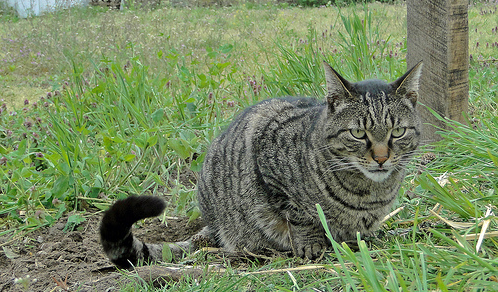

In [23]:
image = Image.open('simat_db/images/images/98316.png')
print('Query Image:')
display(image)

CLIP retrieval without finetuning


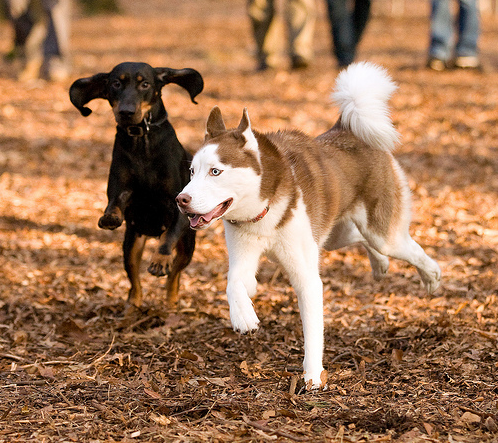

In [36]:
img_enc = model.encode_image(prep(image).unsqueeze(0).to(device)).float().cpu().detach()

txt = ['cat', 'dog']
txt_enc = model.encode_text(clip.tokenize(txt).to(device)).float().cpu().detach()

# now we perform the transformation step
lbd = 3
target_enc = img_enc.normalize() + lbd * (txt_enc[1].normalize() - txt_enc[0].normalize())


retrieved_idx = (db_stacked.normalize() @ target_enc.float().T).argmax(0).item()

retrieved_rid = idx2rid[retrieved_idx]


print('CLIP retrieval without finetuning')
display(Image.open(f'simat_db/images/images/{retrieved_rid}.png'))

CLIP retrieval with finetuning, tau=0.1


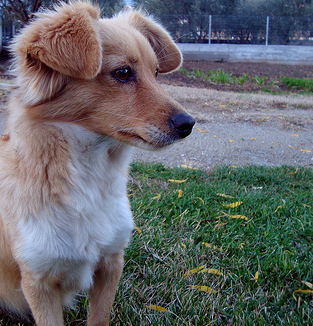

In [43]:
# optionally, we can apply a linear layer on top of the embeddings
heads = torch.load(f'data/head_clip_t=0.1.pt')
img_enc_ = heads['img_head'](img_enc).normalize()
txt_enc_ = heads['txt_head'](txt_enc).normalize()
db2 = heads['img_head'](db_stacked).normalize()


# now we perform the transformation step
lbd = 1.2
target_enc = img_enc_ + lbd * (txt_enc_[1] - txt_enc_[0])


retrieved_idx = (db2 @ target_enc.float().T).argmax(0).item()

retrieved_rid = idx2rid[retrieved_idx]

print('CLIP retrieval with finetuning, tau=0.1')

display(Image.open(f'simat_db/images/images/{retrieved_rid}.png'))